In [1]:
import pandas as pd
import numpy as np
import os,sys
import tensorflow as tf
from keras.preprocessing.image import Iterator,load_img
from keras import layers
from keras import models
from keras import optimizers
import math 
import matplotlib.pyplot as plt
import PIL
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

In [2]:
dirname = os.path.abspath('data/uw-madison-gi-tract-image-segmentation')
print(dirname)

C:\Users\catia\UWMadisonGITractImageSegmentation\data\uw-madison-gi-tract-image-segmentation


In [3]:
#carrega dados training
csv_train_filename_prefix = "train.csv"
dir_training="train"

## Training
path_training = os.path.join(dirname, dir_training)

ficheiros_training = set(x for x in os.listdir(path_training))
print("Numero de ficheiros Training:", len(ficheiros_training))

n=len(ficheiros_training)

a_fnames_training = sorted(os.listdir(path_training))

filenames_training=list(ficheiros_training)   

Numero de ficheiros Training: 85


In [4]:
#processa dados training
path_csv_train = os.path.join(dirname,csv_train_filename_prefix)

data_training = pd.read_csv(path_csv_train)

ID_training=data_training.iloc[:,0]
Class_training=data_training.iloc[:,1]
Segmentation_training=data_training.iloc[:,2]
print(ID_training.head())
print(Class_training.head())
print(Segmentation_training.head())
print(len(ID_training))

0    case123_day20_slice_0001
1    case123_day20_slice_0001
2    case123_day20_slice_0001
3    case123_day20_slice_0002
4    case123_day20_slice_0002
Name: id, dtype: object
0    large_bowel
1    small_bowel
2        stomach
3    large_bowel
4    small_bowel
Name: class, dtype: object
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: segmentation, dtype: object
115488


In [5]:
cases= os.listdir(path_training)
print(cases)
scans=list()
input_img_paths=list()
input_imgs=list()
image_paths=list()
full_path=list()
target_dir="annotations"
target_paths=list()
labels_path=list()
days=list()
for case in cases:
    days_new=os.listdir(os.path.join(path_training,case))
    days.append(os.listdir(os.path.join(path_training,case)))
    for day in days_new:
        scans.append(os.listdir(os.path.join(path_training,case,day,"scans")))
        for scan in scans:
            images=[image.split(",") for image in scan]
        for image in images:
            newImage=''.join(image)
            imageSplit=newImage.split("_")
            #print(imageSplit)
            labelToCompare=day+"_"+imageSplit[0]+"_"+imageSplit[1]
            #print(labelToCompare)
            labels_path.append(labelToCompare)
            #print(image)
            #print(labels_path)
            full_path.append(os.path.join(dirname,path_training,case,day,"scans",newImage))
            target_paths.append(os.path.join(dirname,path_training,case,day,"scans",newImage))
            image_paths.append(os.path.join(dirname,path_training,case,day,"scans",labelToCompare))       
print(labels_path[1])
print(len(labels_path))

['case101', 'case102', 'case107', 'case108', 'case11', 'case110', 'case111', 'case113', 'case114', 'case115', 'case116', 'case117', 'case118', 'case119', 'case121', 'case122', 'case123', 'case124', 'case125', 'case129', 'case130', 'case131', 'case133', 'case134', 'case135', 'case136', 'case138', 'case139', 'case140', 'case141', 'case142', 'case143', 'case144', 'case145', 'case146', 'case147', 'case148', 'case149', 'case15', 'case154', 'case156', 'case16', 'case18', 'case19', 'case2', 'case20', 'case22', 'case24', 'case29', 'case30', 'case32', 'case33', 'case34', 'case35', 'case36', 'case40', 'case41', 'case42', 'case43', 'case44', 'case47', 'case49', 'case53', 'case54', 'case55', 'case58', 'case6', 'case63', 'case65', 'case66', 'case67', 'case7', 'case74', 'case77', 'case78', 'case80', 'case81', 'case84', 'case85', 'case88', 'case89', 'case9', 'case90', 'case91', 'case92']
case101_day20_slice_0002
38496


In [6]:
print(target_paths[1])

C:\Users\catia\UWMadisonGITractImageSegmentation\data\uw-madison-gi-tract-image-segmentation\train\case101\case101_day20\scans\slice_0002_266_266_1.50_1.50.png


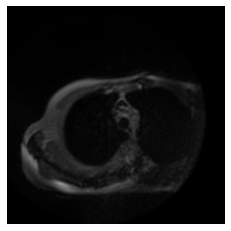

In [7]:
#exaple of image load
plt.axis("off")

plt.imshow(load_img(target_paths[5]))

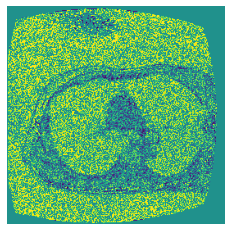

In [8]:
def display_target(target_array):
    normalized_array=(target_array.astype("uint8")-1)*127
    plt.axis("off")
    plt.imshow(normalized_array[:,:,0])
    
img=img_to_array(load_img(target_paths[25],color_mode="grayscale"))
display_target(img)

In [9]:
#processa dados testing - para testes pois nao temos o test set
path_csv_test = os.path.join(dirname,csv_train_filename_prefix)

data_testing= pd.read_csv(path_csv_train)

ID_testing=data_testing.iloc[:,0]
Class_testing=data_testing.iloc[:,1]
Segmentation_testing=data_testing.iloc[:,2]
print(ID_testing)
print(Class_testing.head())
print(Segmentation_testing.head()) 

0         case123_day20_slice_0001
1         case123_day20_slice_0001
2         case123_day20_slice_0001
3         case123_day20_slice_0002
4         case123_day20_slice_0002
                    ...           
115483      case30_day0_slice_0143
115484      case30_day0_slice_0143
115485      case30_day0_slice_0144
115486      case30_day0_slice_0144
115487      case30_day0_slice_0144
Name: id, Length: 115488, dtype: object
0    large_bowel
1    small_bowel
2        stomach
3    large_bowel
4    small_bowel
Name: class, dtype: object
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: segmentation, dtype: object


In [10]:
img_size=(120,120)
num_imgs=len(full_path)
print(num_imgs)

#for i in range(20):
#    print(full_path[i])

38496


In [ ]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img=img_to_array(
    load_img(path,target_size=img_size,color_mode="grayscale"))
    img=img.astype("uint8")-1
    return img

input_imgs=np.zeros((num_imgs,)+img_size+(3,),dtype="float32")
targets=np.zeros((num_imgs,)+img_size+(1,),dtype="uint8")

for i in range(num_imgs):
    input_imgs[i]=path_to_input_image(full_path[i])
    targets[i]=path_to_target(target_paths[i])
    
num_val_samples=4000
train_input_imgs=input_imgs[:-num_val_samples]
train_targets=targets[:-num_val_samples]
val_input_imgs=input_imgs[-num_val_samples:]
val_targets=targets[-num_val_samples:]

In [50]:


labels=sorted(list(Class_training.items()))
#print(labels)
print(len(labels))
#print(labels)
#print(days)
#print(scans)
#print(ID_testing[0])

new_labels_path=sorted(labels_path)
new_images_path=sorted(target_paths)
#print(new_labels_path[1])
newLabels=list()
new_ID_training=sorted(ID_training)
print(len(new_labels_path))
print(len(new_ID_training))
for i in range(len(new_labels_path)):
    #print(newLabel)
    #print(new_ID_training[0])
    if new_labels_path[i] in new_ID_training: 
        newLabels.append(labels[i])
print(len(newLabels))


115488
38496
115488
38496


In [51]:
print(len(train_input_imgs))

32496


In [52]:
print(num_imgs)

38496


In [101]:
#labelsToModel=list()
from tensorflow.keras.utils import to_categorical

labelsToModel=[label[1] for label in newLabels]
normalized_target=list()
labels=list()
for i in range(len(labelsToModel)):
    if labelsToModel[i]=="small_bowel":
        labelsToModel[i]=1
        normalized_target.append((labelsToModel[i]-1)*127)

    elif labelsToModel[i]=="stomach":
        labelsToModel[i]=2
        normalized_target.append((labelsToModel[i]-1)*127)

    elif labelsToModel[i]=="large_bowel":
        labelsToModel[i]=3
        normalized_target.append((labelsToModel[i]-1)*127)


for i in range(num_imgs):
    labels.append(normalized_target[i])
    
print(len(labels))

38496


In [104]:
batch_size=32
img_height = 120
img_width = 120

train_ds = tf.keras.utils.image_dataset_from_directory(
  path_training,
  labels=labels,
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  path_training,
  labels=labels,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 38496 files belonging to 85 classes.
Using 30797 files for training.
Found 38496 files belonging to 85 classes.
Using 7699 files for validation.


In [94]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size,num_classes):
    inputs=keras.Input(shape=img_size+(3,))
    x=layers.Rescaling(1./255)(inputs)

    x=layers.Conv2D(64, 3, strides=2, activation='relu', padding="same")(x)
    x=layers.Conv2D(64, 3, activation='relu', padding="same")(x)
    x=layers.Conv2D(128, 3, strides=2, activation='relu', padding="same")(x)
    x=layers.Conv2D(128, 3, activation='relu', padding="same")(x)
    x=layers.Conv2D(256, 3, strides=2, activation='relu', padding="same")(x)
    x=layers.Conv2D(256, 3, activation='relu', padding="same")(x)

    x=layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x=layers.Conv2DTranspose(256, 3, activation="relu", padding="same",strides=2)(x)
    x=layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x=layers.Conv2DTranspose(128, 3, activation="relu", padding="same",strides=2)(x)
    x=layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x=layers.Conv2DTranspose(64, 3, activation="relu", padding="same",strides=2)(x)

    outputs=layers.Conv2D(num_classes,3,activation="softmax",padding="same")(x)

    model=keras.Model(inputs, outputs)
    return model

model=get_model(img_size=img_size,num_classes=3)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 120, 120, 3)]     0         
                                                                 
 rescaling_10 (Rescaling)    (None, 120, 120, 3)       0         
                                                                 
 conv2d_65 (Conv2D)          (None, 60, 60, 64)        1792      
                                                                 
 conv2d_66 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 conv2d_67 (Conv2D)          (None, 30, 30, 128)       73856     
                                                                 
 conv2d_68 (Conv2D)          (None, 30, 30, 128)       147584    
                                                                 
 conv2d_69 (Conv2D)          (None, 15, 15, 256)       2951

In [95]:
model.compile(
  optimizer='rmsprop',
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy'])

callbacks=[keras.callbacks.ModelCheckpoint("intestinal_segmentation.keras",save_best_only=True)]

In [96]:
history=model.fit(train_ds,
                 epochs=50,
                 callbacks=callbacks,
                 batch_size=32,
                  validation_data = val_ds)

Epoch 1/50


ValueError: in user code:

    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 864, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\metrics.py", line 729, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\metrics.py", line 4086, in sparse_categorical_accuracy
        return tf.cast(tf.equal(y_true, y_pred), backend.floatx())

    ValueError: Dimensions must be equal, but are 85 and 120 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](IteratorGetNext:1, Cast_1)' with input shapes: [?,85], [?,120,120].


In [ ]:
epochs=range(1,len(history.history["loss"])+1)
loss=history.history["loss"]

In [ ]:
val_loss=history.history["val_loss"]
plt.figure()
plt.plot(epochs,loss,"bo",label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and validation loss")
plt.legend()